In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from catboost import CatBoostRegressor, CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
# для нейронки
from sklearn.preprocessing import LabelEncoder
# #from tensorflow.keras import Sequential
# import keras
# #from tensorflow.keras import layers, callbacks
# # from tensorflow.keras import Sequential
# # from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# # from tensorflow.keras.optimizers import Adam
# #from keras.metrics import BinaryAccuracy, AUC

# from keras.models import Sequential
# #from tensorflow import keras
# from keras.layers import Dense, SimpleRNN, Activation, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, Dropout
# from keras import optimizers
# from keras.utils import to_categorical



In [4]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='mako')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

In [5]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [6]:
RANDOM = 42

# LOADING DATA

In [7]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

In [8]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,30.0,30.0,44.50,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
5,YMH,42.0,20.0,86.00,0
6,YMJ,50.0,29.0,48.00,0
7,KSD,0.0,0.0,0.00,0
8,YML,60.0,40.0,45.00,1
9,YMN,60.0,60.0,40.00,0


In [9]:
# явно отсортированные
not_need_box = [360, 340]

In [10]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

carton_price.columns = ['cartontype', 'price']
carton.columns = [s.lower() for s in carton.columns]

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [12]:
corr_test = pd.merge(sku_cargotypes, data[['sku', 'selected_cartontype']], on='sku', how='left')

In [13]:
corr_test['selected_cartontype'] = label_encoder.fit_transform(corr_test['selected_cartontype'])

In [14]:
corr_test[['cargotype', 'selected_cartontype']].corr() # корреляция категория тип упаковки

,cargotype,selected_cartontype
cargotype,1.000000,0.021945
selected_cartontype,0.021945,1.000000


In [15]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
#sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype not in @mb_not_important') # дропаем как мне кажется не особо важные
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups.head()

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"


In [16]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [17]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [18]:
non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [19]:
# фичи для упаковок, для сравнения с фичами заказа
new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
new_carton = new_carton.rename(
    columns={
        'level_0': 'carton_dim',
        0: 'value'
})

new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
new_carton_t =  new_carton.set_index('carton_type_dim').T

In [20]:
df = data.copy()

In [21]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [22]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


In [23]:
# не хватает оперативки

# mlb = MultiLabelBinarizer()
# one_hot = mlb.fit_transform(sku_groups['cargotype'])

# one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
# one_hot_df['sku'] = sku_groups['sku']
# df = pd.merge(df, one_hot_df, on='sku', how='left')

In [24]:
sku = sku[sku['vol']>0]

In [25]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4


In [26]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [27]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [28]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


In [29]:
df_sum = df.drop(['selected_carton', 'sku'], axis=1).groupby('orderkey', sort=False).sum() # суммируем по заказам

In [30]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9


In [31]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [32]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [33]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2,NONPACK,101.0,33.666667,25168.000,1.0,3.4,1.0,0.5,28.6,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0,MYB,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,23.5


In [34]:
new_carton_t

carton_type_dim,length_YMA,length_YMC,length_YME,length_YMF,length_YMG,length_YMH,length_YMJ,length_YML,length_YMN,length_YMO,length_YMP,length_YMQ,length_YMR,length_YMS,length_YMU,length_YMV,length_YMW,length_YMХ,length_MYF,length_YMX,length_YMY,length_MYA,length_MYB,length_MYC,length_MYD,length_MYE,width_YMA,width_YMC,width_YME,width_YMF,width_YMG,width_YMH,width_YMJ,width_YML,width_YMN,width_YMO,width_YMP,width_YMQ,width_YMR,width_YMS,width_YMU,width_YMV,width_YMW,width_YMХ,width_MYF,width_YMX,width_YMY,width_MYA,width_MYB,width_MYC,width_MYD,width_MYE,height_YMA,height_YMC,height_YME,height_YMF,height_YMG,height_YMH,height_YMJ,height_YML,height_YMN,height_YMO,height_YMP,height_YMQ,height_YMR,height_YMS,height_YMU,height_YMV,height_YMW,height_YMХ,height_MYF,height_YMX,height_YMY,height_MYA,height_MYB,height_MYC,height_MYD,height_MYE,displayrfpack_YMA,displayrfpack_YMC,displayrfpack_YME,displayrfpack_YMF,displayrfpack_YMG,displayrfpack_YMH,displayrfpack_YMJ,displayrfpack_YML,displayrfpack_YMN,displayrfpack_YMO,displayrfpack_YMP,displayrfpack_YMQ,displayrfpack_YMR,displayrfpack_YMS,displayrfpack_YMU,displayrfpack_YMV,displayrfpack_YMW,displayrfpack_YMХ,displayrfpack_MYF,displayrfpack_YMX,displayrfpack_YMY,displayrfpack_MYA,displayrfpack_MYB,displayrfpack_MYC,displayrfpack_MYD,displayrfpack_MYE,dim_sum_YMA,dim_sum_YMC,dim_sum_YME,dim_sum_YMF,dim_sum_YMG,dim_sum_YMH,dim_sum_YMJ,dim_sum_YML,dim_sum_YMN,dim_sum_YMO,dim_sum_YMP,dim_sum_YMQ,dim_sum_YMR,dim_sum_YMS,dim_sum_YMU,dim_sum_YMV,dim_sum_YMW,dim_sum_YMХ,dim_sum_MYF,dim_sum_YMX,dim_sum_YMY,dim_sum_MYA,dim_sum_MYB,dim_sum_MYC,dim_sum_MYD,dim_sum_MYE,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,dim_mean_YMA,dim_mean_YMC,dim_mean_YME,dim_mean_YMF,dim_mean_YMG,dim_mean_YMH,dim_mean_YMJ,dim_mean_YML,dim_mean_YMN,dim_mean_YMO,dim_mean_YMP,dim_mean_YMQ,dim_mean_YMR,dim_mean_YMS,dim_mean_YMU,dim_mean_YMV,dim_mean_YMW,dim_mean_YMХ,dim_mean_MYF,dim_mean_YMX,dim_mean_YMY,dim_mean_MYA,dim_mean_MYB,dim_mean_MYC,dim_mean_MYD,dim_mean_MYE,dim_median_YMA,dim_median_YMC,dim_median_YME,dim_median_YMF,dim_median_YMG,dim_median_YMH,dim_median_YMJ,dim_median_YML,dim_median_YMN,dim_median_YMO,dim_median_YMP,dim_median_YMQ,dim_median_YMR,dim_median_YMS,dim_median_YMU,dim_median_YMV,dim_median_YMW,dim_median_YMХ,dim_median_MYF,dim_median_YMX,dim_median_YMY,dim_median_MYA,dim_median_MYB,dim_median_MYC,dim_median_MYD,dim_median_MYE,prod_a_b_YMA,prod_a_b_YMC,prod_a_b_YME,prod_a_b_YMF,prod_a_b_YMG,prod_a_b_YMH,prod_a_b_YMJ,prod_a_b_YML,prod_a_b_YMN,prod_a_b_YMO,prod_a_b_YMP,prod_a_b_YMQ,prod_a_b_YMR,prod_a_b_YMS,prod_a_b_YMU,prod_a_b_YMV,prod_a_b_YMW,prod_a_b_YMХ,prod_a_b_MYF,prod_a_b_YMX,prod_a_b_YMY,prod_a_b_MYA,prod_a_b_MYB,prod_a_b_MYC,prod_a_b_MYD,prod_a_b_MYE,prod_a_c_YMA,prod_a_c_YMC,prod_a_c_YME,prod_a_c_YMF,prod_a_c_YMG,prod_a_c_YMH,prod_a_c_YMJ,prod_a_c_YML,prod_a_c_YMN,prod_a_c_YMO,prod_a_c_YMP,prod_a_c_YMQ,prod_a_c_YMR,prod_a_c_YMS,prod_a_c_YMU,prod_a_c_YMV,prod_a_c_YMW,prod_a_c_YMХ,prod_a_c_MYF,prod_a_c_YMX,prod_a_c_YMY,prod_a_c_MYA,prod_a_c_MYB,prod_a_c_MYC,prod_a_c_MYD,prod_a_c_MYE,prod_b_c_YMA,prod_b_c_YMC,prod_b_c_YME,prod_b_c_YMF,prod_b_c_YMG,prod_b_c_YMH,prod_b_c_YMJ,prod_b_c_YML,prod_b_c_YMN,prod_b_c_YMO,prod_b_c_YMP,prod_b_c_YMQ,prod_b_c_YMR,prod_b_c_YMS,prod_b_c_YMU,prod_b_c_YMV,prod_b_c_YMW,prod_b_c_YMХ,prod_b_c_MYF,prod_b_c_YMX,prod_b_c_YMY,prod_b_c_MYA,prod_b_c_MYB,prod_b_c_MYC,prod_b_c_MYD,prod_b_c_MYE,prod_min_YMA,prod_min_YMC,prod_min_YME,prod_min_YMF,prod_min_YMG,prod_min_YMH,prod_min_YMJ,prod_min_YML,prod_min_YMN,prod_min_YMO,prod_min_YMP,prod_min_YMQ,prod_min_YMR,prod_min_YMS,prod_min_YMU,prod_min_YMV,prod_min_YMW,prod_min_YMХ,prod_min_MYF,prod_min_YMX,prod_min_YMY,prod_min_MYA,prod_min_MYB,prod_min_MYC,prod_min_MYD,prod_min_MYE,prod_mean_YMA,prod_mean_YMC,prod_mean_YME,prod_mean_YMF,prod_mean_YMG,prod_mean_YMH,

In [35]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [36]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
# df_sum[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='length').columns.tolist()] = new_carton_t[new_carton_t.filter(like='length').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [37]:
df_sum.head(3)

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,diag_YMA,diag_YMC,diag_YME,diag_YMF,diag_YMG,diag_YMH,diag_YMJ,diag_YML,diag_YMN,diag_YMO,diag_YMP,diag_YMQ,diag_YMR,diag_YMS,diag_YMU,diag_YMV,diag_YMW,diag_YMХ,diag_MYF,diag_YMX,diag_YMY,diag_MYA,diag_MYB,diag_MYC,diag_MYD,diag_MYE,length_YMA,length_YMC,length_YME,length_YMF,length_YMG,length_YMH,length_YMJ,length_YML,length_YMN,length_YMO,length_YMP,length_YMQ,length_YMR,length_YMS,length_YMU,length_YMV,length_YMW,length_YMХ,length_MYF,length_YMX,length_YMY,length_MYA,length_MYB,length_MYC,length_MYD,length_MYE
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0


In [38]:
df = df.drop('orderkey', axis=1)

In [39]:
df

,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


<Axes: >

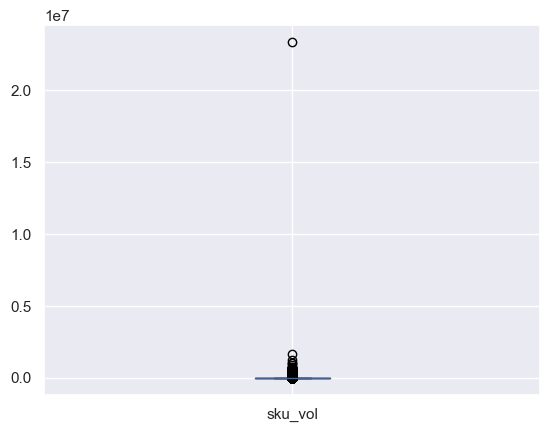

In [40]:
df_sum['sku_vol'].plot(kind='box')

In [41]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

<Axes: >

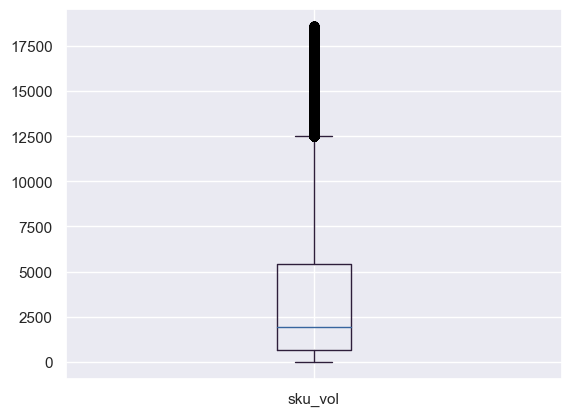

In [42]:
df_no_outlier_vol['sku_vol'].plot(kind='box')

In [43]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [44]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag,vol_YMA,vol_YMC,vol_YME,vol_YMF,vol_YMG,vol_YMH,vol_YMJ,vol_YML,vol_YMN,vol_YMO,vol_YMP,vol_YMQ,vol_YMR,vol_YMS,vol_YMU,vol_YMV,vol_YMW,vol_YMХ,vol_MYF,vol_YMX,vol_YMY,vol_MYA,vol_MYB,vol_MYC,vol_MYD,vol_MYE,diag_YMA,diag_YMC,diag_YME,diag_YMF,diag_YMG,diag_YMH,diag_YMJ,diag_YML,diag_YMN,diag_YMO,diag_YMP,diag_YMQ,diag_YMR,diag_YMS,diag_YMU,diag_YMV,diag_YMW,diag_YMХ,diag_MYF,diag_YMX,diag_YMY,diag_MYA,diag_MYB,diag_MYC,diag_MYD,diag_MYE,length_YMA,length_YMC,length_YME,length_YMF,length_YMG,length_YMH,length_YMJ,length_YML,length_YMN,length_YMO,length_YMP,length_YMQ,length_YMR,length_YMS,length_YMU,length_YMV,length_YMW,length_YMХ,length_MYF,length_YMX,length_YMY,length_MYA,length_MYB,length_MYC,length_MYD,length_MYE
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.6,39.1,61.5,45.6,57.4,97.8,75.1,85.0,93.8,81.5,79.3,100.5,128.1,118.3,36.3,47.2,52.2,78.4,25.5,78.4,89.5,25.2,39.1,49.0,63.3,76.9,24.7,30.0,30.0,35.0,44.7,42.0,50.0,60.0,60.0,65.0,70.0,70.0,80.0,89.5,27.0,37.0,40.0,40.0,20.0,40.0,52.0,15.0,22.0,30.0,38.0,43.0
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,29.0,9.0,29.0,67.0,7569.0,22.0,29.0,261.0,841.0,261.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,1.0,3.2,1.0,8.0,209.7,33.4,3705.0,9000.0,40050.0,13125.0,26820.0,72240.0,69600.0,108000.0,144000.0,58500.0,46200.0,168000.0,384000.0,263599.0,2592.0,4292.0,18000.0,46800.0,1500.0,46800.0,72800.0,999.0,3449.0,8436.0,15579.0,26277.0,30.

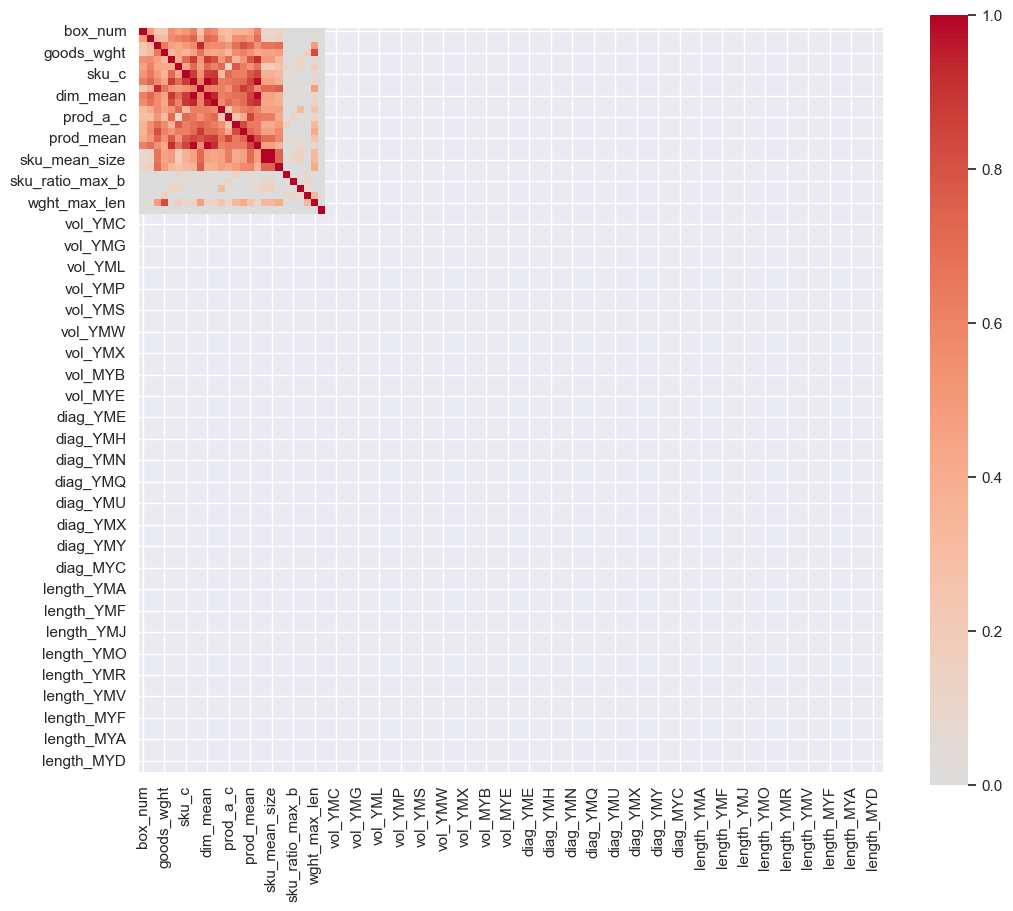

In [45]:
numeric_columns = df_no_outlier_vol.loc[:,df_no_outlier_vol.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            #annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [46]:
corr_feat = set()
corr_matrix = df_no_outlier_vol[numeric_columns].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{'diag',
 'dim_mean',
 'dim_median',
 'dim_sum',
 'prod_mean',
 'prod_min',
 'sku_mean_size',
 'sku_vol'}

In [47]:
# Проверить
df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

In [48]:
# fltr_nonpack =  ["STRETCH", "NONPACK"] # 
# df_no_outlier_vol = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')
# df_no_outlier_vol

# Модель 1

In [78]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"') # один случай дропаем из-за stratify

In [79]:
df_no_outlier_vol = df_no_outlier_vol.dropna()

In [80]:
df_no_outlier_vol['selected_carton'].value_counts()

selected_carton
MYB        39498
MYC        29024
MYA        14358
MYD        12772
YMC         7916
NONPACK     7823
YMA         6729
STRETCH     5321
YMF         4036
MYE         3959
YMW         3407
YMG         2560
MYF          789
YME          322
YMX           29
YML            7
Name: count, dtype: int64

In [81]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']

In [82]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [54]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')


In [83]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [95]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostClassifier(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        iterations=500,
        #subsample=0.1,
        #max_depth=5,
        verbose=10,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        #eval_metric='TotalF1'
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.180112
0:	learn: 2.2387046	total: 365ms	remaining: 3m 1s
10:	learn: 1.5931771	total: 4.15s	remaining: 3m 4s
20:	learn: 1.5151005	total: 7.33s	remaining: 2m 47s
30:	learn: 1.4875709	total: 10.1s	remaining: 2m 33s
40:	learn: 1.4714702	total: 13s	remaining: 2m 25s
50:	learn: 1.4599087	total: 15.8s	remaining: 2m 18s
60:	learn: 1.4499517	total: 18.5s	remaining: 2m 12s
70:	learn: 1.4424762	total: 21.3s	remaining: 2m 8s
80:	learn: 1.4342841	total: 24.1s	remaining: 2m 4s
90:	learn: 1.4280895	total: 27.2s	remaining: 2m 2s
100:	learn: 1.4203542	total: 30.2s	remaining: 1m 59s
110:	learn: 1.4144551	total: 33.2s	remaining: 1m 56s
120:	learn: 1.4088368	total: 36s	remaining: 1m 52s
130:	learn: 1.4041954	total: 38.9s	remaining: 1m 49s
140:	learn: 1.3988877	total: 42s	remaining: 1m 47s
150:	learn: 1.3940163	total: 44.9s	remaining: 1m 43s
160:	learn: 1.3890374	total: 47.9s	remaining: 1m 40s
170:	learn: 1.3843534	total: 50.8s	remaining: 1m 37s
180:	learn: 1.3805415	total: 53.7s	rem

Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x000001A1E979F880>)])

Text(0.5, 1.0, 'Feature Importance')

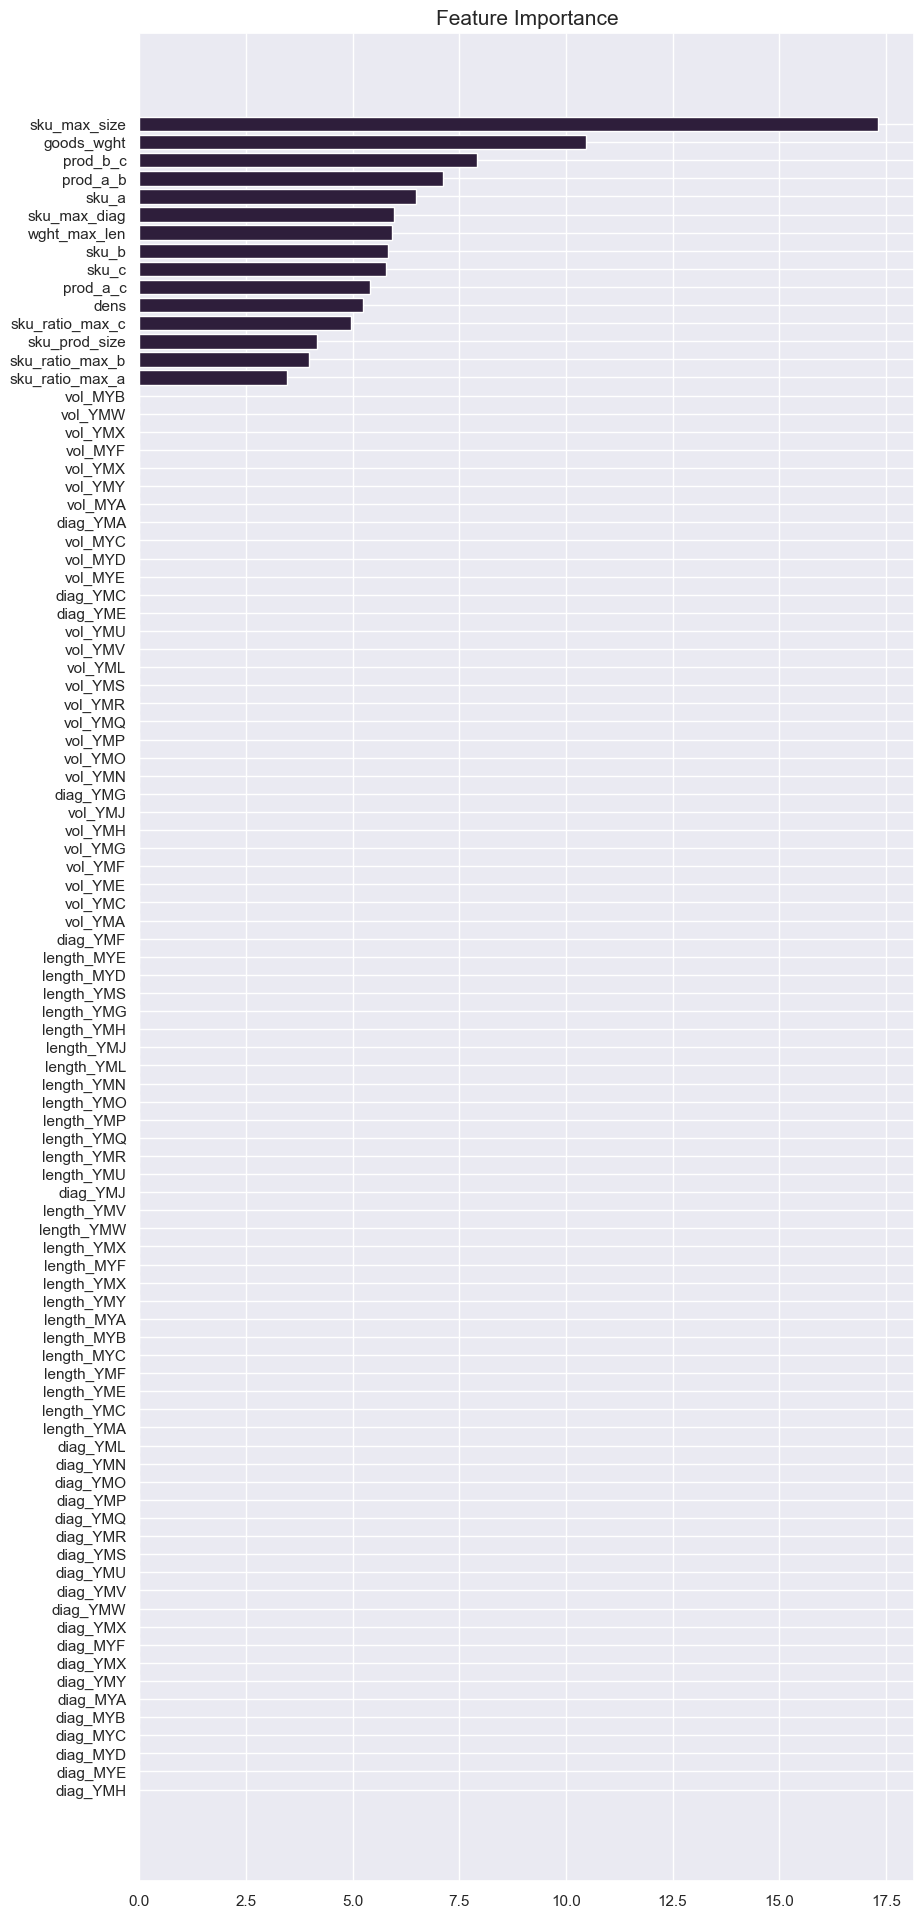

In [96]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [97]:
tree_preds = tree_pipe.predict(X_test)
tree_pred_proba = tree_pipe.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')

print(classification_report(y_test, tree_preds))

TRAIN ACC: 0.5411598275463854
TEST ACC: 0.48960679023038284
TEST F1: 0.4755689755388537
              precision    recall  f1-score   support

         MYA       0.56      0.44      0.49      3590
         MYB       0.59      0.69      0.64      9875
         MYC       0.48      0.55      0.51      7256
         MYD       0.37      0.45      0.40      3193
         MYE       0.25      0.13      0.17       990
         MYF       0.00      0.00      0.00       197
     NONPACK       0.51      0.55      0.53      1956
     STRETCH       0.35      0.22      0.27      1330
         YMA       0.43      0.15      0.23      1682
         YMC       0.38      0.36      0.37      1979
         YME       1.00      0.03      0.05        80
         YMF       0.26      0.22      0.24      1009
         YMG       0.35      0.31      0.33       640
         YML       0.00      0.00      0.00         2
         YMW       0.28      0.30      0.29       852
         YMX       0.00      0.00      0.00    

In [88]:
y_proba = tree_pipe.predict_proba(X_test[100:110])

# два наиболее вероятных класса с вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = tree_pipe.classes_[top_two[i]]
    print(f"Для заказа № {i} рекомендуется упаковка: {class_names[0]}, {top_two_proba[i][0]*100}% или {class_names[1]}, {top_two_proba[i][1]*100}%, тест {y_test.iloc[i]}")

Для заказа № 0 рекомендуется упаковка: YMG, 21.0% или YMW, 53.0%, тест STRETCH
Для заказа № 1 рекомендуется упаковка: MYB, 43.0% или MYC, 47.0%, тест MYC
Для заказа № 2 рекомендуется упаковка: STRETCH, 40.0% или NONPACK, 60.0%, тест YMF
Для заказа № 3 рекомендуется упаковка: MYC, 26.0% или YMA, 53.0%, тест STRETCH
Для заказа № 4 рекомендуется упаковка: YMA, 11.0% или MYB, 73.0%, тест MYB
Для заказа № 5 рекомендуется упаковка: MYB, 33.0% или MYA, 62.0%, тест MYB
Для заказа № 6 рекомендуется упаковка: MYC, 25.0% или MYB, 59.0%, тест MYC
Для заказа № 7 рекомендуется упаковка: MYC, 10.0% или YMC, 65.0%, тест MYC
Для заказа № 8 рекомендуется упаковка: MYA, 26.0% или MYB, 60.0%, тест YMF
Для заказа № 9 рекомендуется упаковка: YMG, 18.0% или YMW, 19.0%, тест YMA


# Модель 2

In [60]:
# расчет по объему поэтому 0 отбрасываем
zero_vol = ['KSD', 'NONPACK', 'STRETCH']

In [61]:
carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

,selected_carton,vol
24,MYA,999.0
21,MYF,1500.0
17,YMU,2592.0
25,MYB,3449.0
0,YMA,3705.0
18,YMV,4292.0
26,MYC,8436.0
1,YMC,9000.0
3,YMF,13125.0
27,MYD,15579.0


In [62]:
df_no_outlier_vol_regr = pd.merge(df_no_outlier_vol, 
         carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}), 
         on='selected_carton', 
         how='left')

df_no_outlier_vol_regr = df_no_outlier_vol_regr.dropna()

In [63]:
X = df_no_outlier_vol_regr.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey', 'vol'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol_regr['vol']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol_regr['vol']
                                                    )

In [64]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostRegressor(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        #iterations=1000,
        #subsample=0.1,
        #max_depth=4,
        verbose=100,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        #loss_function='MultiClass',
        #eval_metric='TotalF1',
        eval_metric="RMSE"
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.083941
0:	learn: 6402.0741386	total: 18.8ms	remaining: 18.8s
100:	learn: 4534.3994558	total: 1.39s	remaining: 12.4s
200:	learn: 4437.4750027	total: 2.79s	remaining: 11.1s
300:	learn: 4370.3981659	total: 4.06s	remaining: 9.43s
400:	learn: 4315.7557691	total: 5.34s	remaining: 7.97s
500:	learn: 4269.8870846	total: 6.74s	remaining: 6.71s
600:	learn: 4229.6221435	total: 8.02s	remaining: 5.32s
700:	learn: 4193.7279394	total: 9.31s	remaining: 3.97s
800:	learn: 4159.9856686	total: 10.6s	remaining: 2.63s
900:	learn: 4129.0508738	total: 11.9s	remaining: 1.31s
999:	learn: 4099.2158836	total: 13.2s	remaining: 0us


Pipeline(steps=[('tree',
                 <catboost.core.CatBoostRegressor object at 0x000001A206D83FA0>)])

Text(0.5, 1.0, 'Feature Importance')

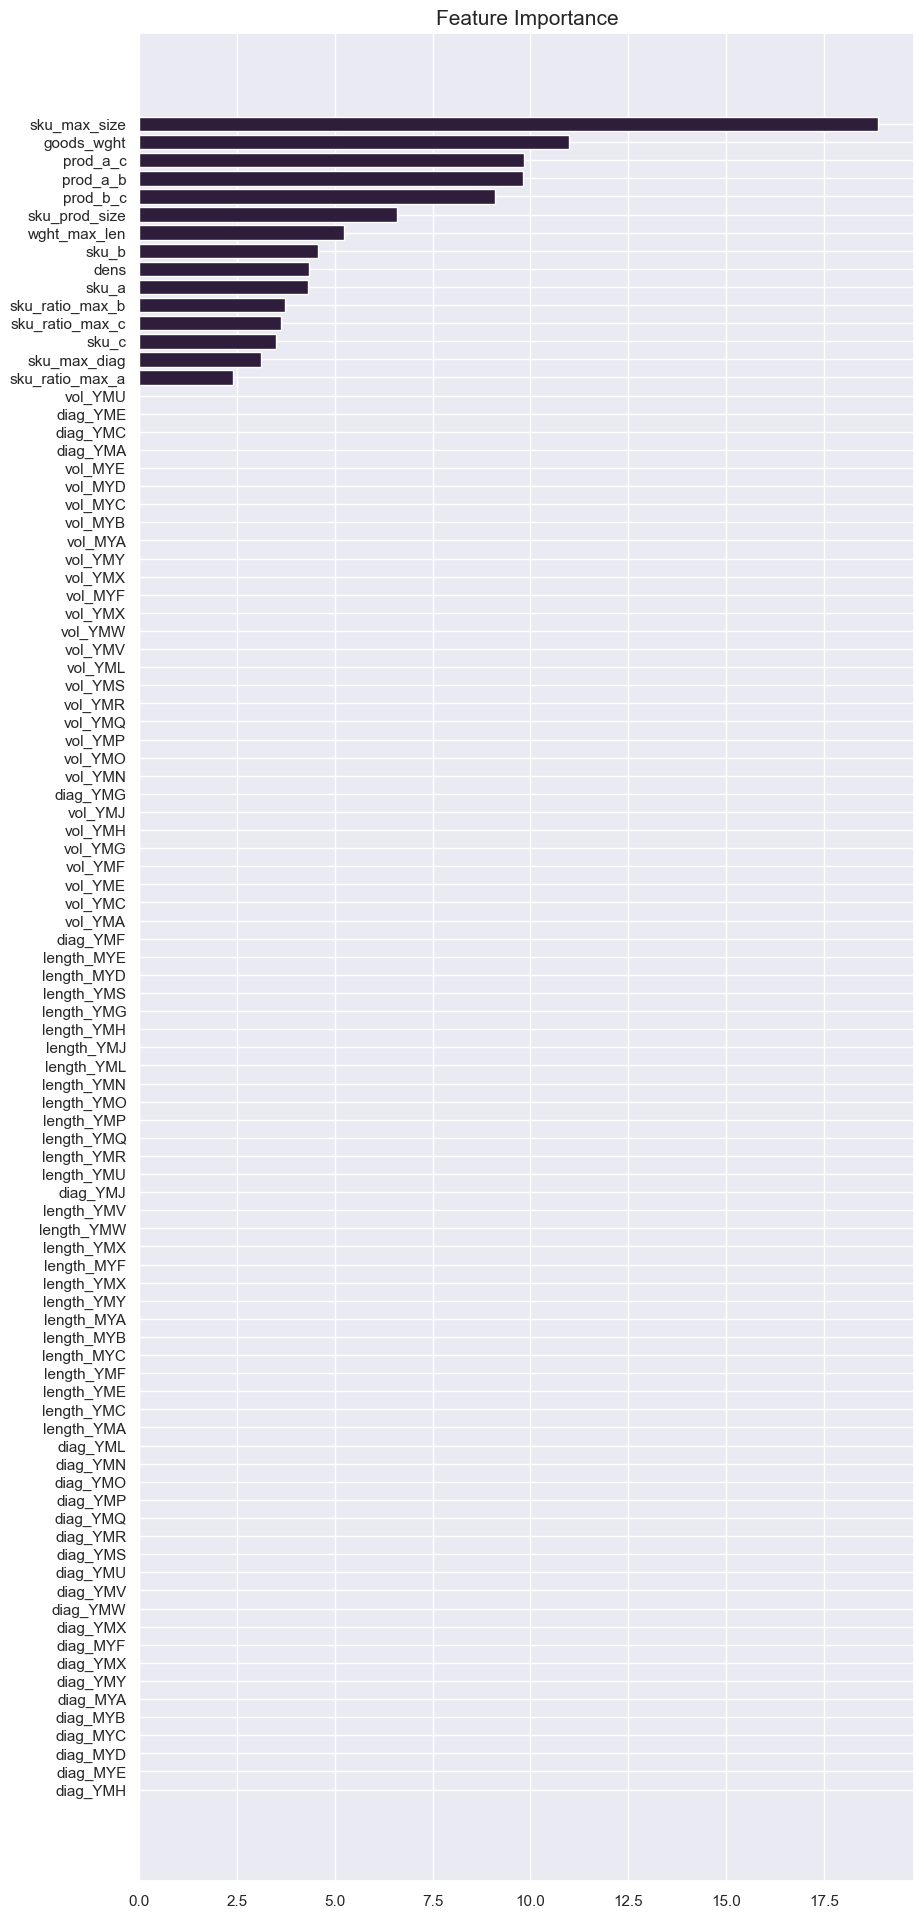

In [65]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [66]:
cartontype_sorted_vol = carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

In [67]:
threshold = y_proba[0]
cartontype_sorted_vol['diff'] = np.abs(cartontype_sorted_vol['vol'] - threshold)
cartontype_sorted_vol = cartontype_sorted_vol.sort_values('diff')

# получение первых двух строк с diff > 0
result = cartontype_sorted_vol[cartontype_sorted_vol['diff'] > 0].head(2)['selected_carton'].values
print(result)

ValueError: operands could not be broadcast together with shapes (26,) (16,) 

# Модель 3

In [ ]:
def base_line(order):
    '''
    Получаем order -- json запрос с перечнем товаров
    ищем минимально возможную упаковку из словаря boxes для всех товаров
    Возвращаем {"orderid": "sdfsdf", "package": "ADC", "status": "ok"}
    !!! нет проверок на типы
    !!! если есть товар который не влезет выдаст None, проверки по остальным не сделает
    '''

    def multiply_min(lst, number):
        '''
        типотеза что сложение предметов в пачку идет в первую очередь по меньшему размеру
        '''
        min_val = min(lst)
        min_index = lst.index(min_val)
        lst[min_index] *= number
        return lst

    orderId = order['orderId']
    bricks = [] # размеры товаров в список
    vol_range = {} # объемы для последующего отсева наиболее объемных
    for i in order['items']:
        sizes = (float(i['size1']), float(i['size2']), float(i['size3']))
        sizes = multiply_min(list(sizes), i['count'])
        vol_range[i['sku']] = float(i['size1']) * float(i['size2']) * float(i['size3'])
        bricks.append(sizes)
        # for j in range(i['count']):
        #
    # размеры коробок
    boxes = {
        'KSD': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'STRETCH': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'NONPACK': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'MYA': {'x': 15.0, 'y': 20.0, 'z': 3.33},
        'MYF': {'x': 20.0, 'y': 15.0, 'z': 5.0},
        'YMU': {'x': 27.0, 'y': 24.0, 'z': 4.0},
        'MYB': {'x': 22.0, 'y': 32.0, 'z': 4.9},
        'YMA': {'x': 24.7, 'y': 15.0, 'z': 10.0},
        'YMV': {'x': 37.0, 'y': 29.0, 'z': 4.0},
        'MYC': {'x': 30.0, 'y': 38.0, 'z': 7.4},
        'YMC': {'x': 30.0, 'y': 20.0, 'z': 15.0},
        'YMF': {'x': 35.0, 'y': 25.0, 'z': 15.0},
        'MYD': {'x': 38.0, 'y': 50.0, 'z': 8.2},
        'YMW': {'x': 40.0, 'y': 30.0, 'z': 15.0},
        'MYE': {'x': 43.0, 'y': 63.0, 'z': 9.7},
        'YMG': {'x': 44.7, 'y': 30.0, 'z': 20.0},
        'YME': {'x': 30.0, 'y': 30.0, 'z': 44.5},
        'YMP': {'x': 70.0, 'y': 30.0, 'z': 22.0},
        'YMХ': {'x': 40.0, 'y': 18.0, 'z': 65.0},
        'YMO': {'x': 65.0, 'y': 45.0, 'z': 20.0},
        'YMJ': {'x': 50.0, 'y': 29.0, 'z': 48.0},
        'YMH': {'x': 42.0, 'y': 20.0, 'z': 86.0},
        'YMY': {'x': 52.0, 'y': 20.0, 'z': 70.0},
        'YML': {'x': 60.0, 'y': 40.0, 'z': 45.0},
        'YMN': {'x': 60.0, 'y': 60.0, 'z': 40.0},
        'YMQ': {'x': 70.0, 'y': 60.0, 'z': 40.0},
        'YMS': {'x': 89.5, 'y': 59.5, 'z': 49.5},
        'YMR': {'x': 80.0, 'y': 60.0, 'z': 80.0}
    }

    def is_fitting(box, bricks):
        for brick in bricks:
            if box['x'] < brick[0] or box['y'] < brick[1] or box['z'] < brick[2]:
                return False
            box = {
                'x': max(box['x'] - brick[0], 0),
                'y': max(box['y'] - brick[1], 0),
                'z': max(box['z'] - brick[2], 0)
            }
        return True

    def find_box(bricks, boxes):
        min_box = None
        min_vol = float('inf')
        for box_name, box in boxes.items():
            if is_fitting(box, bricks):
                vol = box['x'] * box['y'] * box['z']
                if vol < min_vol:
                    min_box = box_name
                    min_vol = vol
        return min_box

    def answer(orderId=orderId, min_box_name='None', status='ok'):
        answer = {}
        answer['orderid'] = orderId
        answer['package'] = min_box_name
        answer['status'] = 'ok'
        return answer

    if find_box(bricks, boxes) != 'None':
        return answer(min_box_name=find_box(bricks, boxes))
    else:
        return answer(min_box_name='STRETCH')

    #
    # while
    #     vol_range.pop(max(vol_range))

    # return min_box_name


order = {"orderId": "af49bf330e2cf16e44f0be1bdfe337bd",
 "items": [
    {"sku": "unique_sku_1", "count": 2,
     "size1": "12", "size2": "6", "size3": "3",
     "weight": "7.34", "type": ["2"]},
    {"sku": "unique_sku_2", "count": 3,
     "size1": "4", "size2": "5.23", "size3": "6.2",
     "weight": "7.45", "type": ["8", "9", "10"]},
    {"sku": "unique_sku_3", "count": 2,
     "size1": "11", "size2": "12.5", "size3": "13.3",
     "weight": "14.2", "type": ["15", "16"]}
   ]
}

print(base_line(order))